<div style='background-image: url("https://www.geophysik.uni-muenchen.de/ROMY/theme/images/ringlaser_wideformat.jpg") ; padding: 0px ; background-size: cover ; border-radius: 15px ; height: 250px; background-position: 0% 80%'>
    <div style="float: left ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.9) ; width: 40% ; height: 150px">
        <div style="position: relative ; top: 50%;  transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.9) ; line-height: 100%">ROMY - <br> <br> Modulation Schemes </div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.7)"></div>
        </div>
    </div>

# Modulation schemes for synthetic Sagnac signal

### Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import matplotlib.pyplot as plt
import obspy 
import time


from scipy.fft import fft
from scipy import optimize
from scipy.signal import butter, lfilter, resample, hilbert, ricker, decimate
from tqdm import tqdm

from andbro__querrySeismoData import __querrySeismoData

### Load Processing Methods

In [2]:
import sys
sys.path.insert(0, 'submodules')

In [3]:
from QuerrySeismoData import __querry_seismo_data
from FastFourierTransform import __fast_fourier_transform
from CreateSyntheticEventV2 import __create_synthetic_event_v2
from Modulation import __modulation
from ResampleDigitalSignal import __resample_digital_signal
from ProcessingModeltrace import __processing_modeltrace
from Interpolation import __interpolation
from TracePadding import __trace_padding
from EchoPerformance import __echo_performance
from Tapering import __tapering
from CreateLinearChirp import __create_linear_chirp
from Normalize import __normalize


### Load Plotting Methods

In [4]:
from MakeplotModulatedSignal import __makeplot_modulated_signal
from MakeplotTraceAndSpectrum import __makeplot_trace_and_spectrum
from MakeplotCompareSchemes import __makeplot_compare_schemes
from MakeplotTraceAndPSD import __makeplot_trace_and_psd


### Setting crucial parameters

In [5]:
from RingLaser import RingLaser

## define G-Ring
G = RingLaser(side=4., form="square", wl=632.8e-9, lat=49.16)
G_sgnc = G.get_sagnac_frequency()


## define ROMY Z-Ring
ROMY_Z = RingLaser(side=11., form="triangle", wl=632.8e-9, lat=49.16)
ROMY_Z_sgnc = ROMY_Z.get_sagnac_frequency()


print(f'Sagnac frequency (G-ring) : {round(G_sgnc,3)} Hz')
print(f'Sagnac frequency (ROMY Z-ring) : {round(ROMY_Z_sgnc,3)} Hz')


Sagnac frequency (G-ring) : 348.721 Hz
Sagnac frequency (ROMY Z-ring) : 553.669 Hz


## Configuration

In [6]:
div = 10
oversampling = 1

T = 1600/div

sps = 5000

sgnc = 553

f_lower, f_upper = 0.01, 5.0


modulation_index = 0.1/f_lower
modulation_index = 0.1


syn_signal = 'synthetic_trace'  ## 'chirp' or 'synthetic_trace' or 'real_trace'



10.0


## Get Synthetic Signal

Depending on varibale: syn_signal, a synthetic signal is loaded or generated. 

#### 1: synthetic_trace: 

A synthetic trace is loaded or generated if not yet existing using ricker wavelets and random spikes. With limited bandwidth. 

#### 2: chirp: 

A chirp with respective bandwidth is generated.

#### 3: real_trace:

Querry data of RLAS for an arbitrary event on 2020-10-30. 

In [7]:
sps = sps * oversampling

In [8]:
if syn_signal == 'synthetic_trace':

    ##_______________________________________________________________
    ## call synthetic event generator (version2)

    modeltrace, time_modeltrace =  __create_synthetic_event_v2(T, 
                                                               sps,
                                                               f_lower,
                                                               f_upper,
                                                               noise=False, 
                                                               padding=10,
                                                              )
    modeltrace = __normalize(modeltrace)

## ______________________________________________
elif syn_signal == 'chirp':
    ##_______________________________________________________________
    ## make chirp signal
    
    modeltrace, time_modeltrace = __create_linear_chirp(T, 
                                                        sps, 
                                                        f_lower, 
                                                        f_upper,
                                                       )

## ______________________________________________
elif syn_signal == 'real_trace':
    
    ## set starttime and endtime
    tbeg = obspy.UTCDateTime(2020, 10, 30, 12, 5)
#     tend = obspy.UTCDateTime(2020, 10, 30, 12, 20)
    tend = tbeg + T
    
    ## get stream data
    RLAS, RLAS_inv = __querry_seismo_data("BW.RLAS..HJZ", 
                                          tbeg, 
                                          tend, 
                                          restitute=True,
                                          )
    
    RLAS[0].resample(sampling_rate=sps)
    
    RLAS[0].filter('bandpass', freqmin=f_lower, freqmax=f_upper, corners=4, zerophase=True)
    
    time_modeltrace = np.arange(0, T+1/sps, 1/sps)
    modeltrace = RLAS[0].data[0:time_modeltrace.size]
    
    ## no normalization but rather scaling with ring scale factor
#     modeltrace = __normalize(modeltrace)
    modeltrace = modeltrace * ROMY_Z.get_scale_factor()
    modulation_index = 0.1
    
#     modeltrace, time_modeltrace = __processing_modeltrace(RLAS, time_shift, duration)

#     __makeplot_trace_and_spectrum(RLAS[0], RLAS[0].times("Matplotlib"), fmax=1.);  
    
## ______________________________________________    
else:
    print("Wrong choise!")
    

In [9]:
modeltrace = __tapering(modeltrace, taper_type='window', percent=0.2)

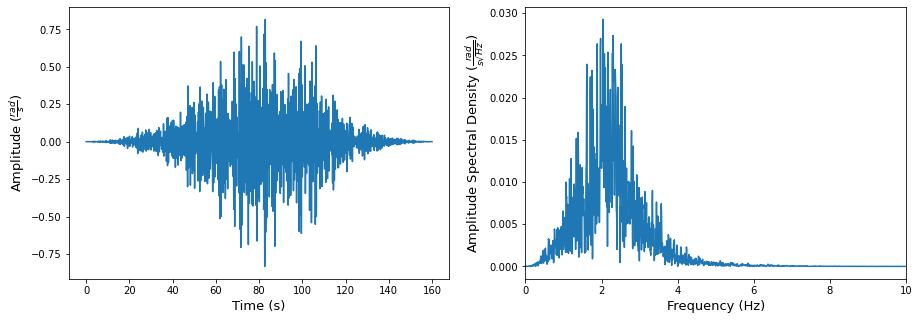

In [10]:
__makeplot_trace_and_spectrum(modeltrace, time_modeltrace, fmax=2*f_upper);

# Modulation

There are 3 different cases implemented for the modulation scheme:

#### case == 1:

$ s_1(t) = A_s \cdot sin( \ 2\pi \ (f_c + \kappa \cdot f_m ) \cdot t \ )$

(often found, simple modulation equation, probaly not correct)

________________________________

#### case == 2:

$ s_2(t) = A_s \cdot sin( \ \omega_c \cdot t - m_{fm} \cdot cos(\omega_m \cdot t ) \ )$

inferred from $\omega_i = \omega_c + sin( \ \omega_m \ \cdot t \ )$;

$\theta = \int \omega_i \delta t  =  \omega_c t - m_{fm} cos( \ \omega_m \ \cdot t \ )$

with $ m_{fm} = \frac{ \Delta f }{ f_m } $

Source: https://en.wikibooks.org/wiki/Communication_Systems/Frequency_Modulation

____________________

#### case == 3: 

$ s(t) = A_s \cdot \sin( \ 2 \pi \cdot \ (f_{c} +  m_{f} \int_0^t f_{mod}(\tau) d\tau )\ ), $

with $f_c$ being the carrier frequency, $A$ the carrier Amplitude and $ m_{f} = \frac{ \Delta f }{ f_{mod} } $ being the modulation index ($\Delta f$ = peak frequency deviation; $f_{mod}$ = maximal frequency of modulation signal).
 

### Compare Schemes

In [11]:
syn_signal_1, timeline_1 = __modulation(modeltrace, time_modeltrace, sgnc, T, sps, modulation_index, case=1)
syn_signal_2, timeline_2 = __modulation(modeltrace, time_modeltrace, sgnc, T, sps, modulation_index, case=2)
syn_signal_3, timeline_3 = __modulation(modeltrace, time_modeltrace, sgnc, T, sps, modulation_index, case=3)


for i, spl in enumerate(timeline_2-timeline_1):
    if spl != 0:
        print(i)


Modulation option 1 is executed ...

Modulation option 2 is executed ...

Modulation option 3 is executed ...

 --> integrating ... 

 elapsed time: 1.34 sec


In [12]:

def __makeplot_compare_modulation2(syn_signal_1, syn_signal_2, syn_signal_3, timeline, sgnc, shift, duration):

    def __welch(syn_signal, sps):

        from scipy.signal import welch
        from numpy.fft import fftshift

        freqs, signal_psd = welch(syn_signal, sps, return_onesided=True, nperseg=1e6, scaling="density")

        return signal_psd, freqs
    
    signal_psd_1, freqs_1 = __welch(syn_signal_1, sps)
    signal_psd_2, freqs_2 = __welch(syn_signal_2, sps)
    signal_psd_3, freqs_3 = __welch(syn_signal_3, sps)

#     signal_psd_1 = 20 * np.log10(signal_psd_1)
#     signal_psd_2 = 20 * np.log10(signal_psd_2)
#     signal_psd_3 = 20 * np.log10(signal_psd_3)
    
    ## _____________________________________________________________________

    fig, ax = plt.subplots(6, 1, figsize=(15,12))

    plt.subplots_adjust(hspace=0.5)

    font = 12
    
    ## _____________________________________________________________________
    ax[0].plot(freqs_1, signal_psd_1,'r')

    ax[0].plot(freqs_2, signal_psd_2,'b')

    ax[0].plot(freqs_3, signal_psd_3,'g')
    
#     ax[0].set_xscale('log')
    ax[0].set_yscale('log')

    ax[0].grid(which='both', alpha=0.5, ls='--') 

    ax[0].set_xlabel('frequency (Hz)',fontsize=font)
    ax[0].set_ylabel(r'PSD ($ \frac{rad^2}{s^2 Hz}$)',fontsize=font)
    
    ax[0].legend(['M1','M2','M3'], loc="upper right")

    ax[0].set_xlim(sgnc-15, sgnc+15)
    
    ax[0].axvline(sgnc, color='darkgrey', ls='--')

    
    ## _____________________________________________________________________
    num1 = int(shift/(timeline[1]-timeline[0]))
    num2 = duration + num1
    
    ax[1].plot(timeline[num1:num2], syn_signal_1[num1:num2],'r')
    ax[1].scatter(timeline[num1:num2], syn_signal_1[num1:num2], s=5, color='r')

    ax[1].plot(timeline[num1:num2], syn_signal_2[num1:num2],'b')
    ax[1].scatter(timeline[num1:num2], syn_signal_2[num1:num2], s=5, color='b')

    ax[1].plot(timeline[num1:num2], syn_signal_3[num1:num2],'g')
    ax[1].scatter(timeline[num1:num2], syn_signal_3[num1:num2], s=5, color='g')

    
    ax[1].set_xlabel('time (s)',fontsize=font)
    ax[1].set_ylabel('amplitude',fontsize=font)

    ax[1].grid(which='both', alpha=0.5, ls='--') 
    
    ax[1].legend(['M1','M2','M3'], loc="upper right")

    ## _____________________________________________________________________

    ax[2].plot(timeline[num1:num2], syn_signal_1[num1:num2]-syn_signal_2[num1:num2],'k', ls='-.')
    
    ax[2].plot(timeline[num1:num2], syn_signal_1[num1:num2]-syn_signal_3[num1:num2],'k', ls='--')

    ax[2].plot(timeline[num1:num2], syn_signal_2[num1:num2]-syn_signal_3[num1:num2],'k', ls=':')

    
    ax[2].set_xlabel('time (s)',fontsize=font)
    ax[2].set_ylabel('residual',fontsize=font)

    ax[2].legend(['M1 - M2', 'M1 - M3', 'M2 - M3'], loc="upper right")

   
    ax[2].grid(which='both', alpha=0.5, ls='--') 

    
    ## _____________________________________________________________________

    ax[3].plot(timeline, syn_signal_1-syn_signal_2,'k', ls='-.')

    ax[3].set_xlabel('time (s)',fontsize=font)
    ax[3].set_ylabel('residual',fontsize=font)

    ax[3].legend(['M1 - M2'], loc="upper right")
    
    ax[3].axvline(shift, color='y')
    
    ## _____________________________________________________________________

    ax[4].plot(timeline, syn_signal_1-syn_signal_3,'k', ls='--')

    ax[4].set_xlabel('time (s)',fontsize=font)
    ax[4].set_ylabel('residual',fontsize=font)

    ax[4].legend(['M1 - M3'], loc="upper right")

    ax[4].axvline(shift, color='y')

    ## _____________________________________________________________________

    ax[5].plot(timeline, syn_signal_2-syn_signal_3,'k', ls=':')

    
    ax[5].set_xlabel('time (s)',fontsize=font)
    ax[5].set_ylabel('residual',fontsize=font)

    ax[5].legend(['M2 - M3'], loc="upper right")

    ax[5].axvline(shift, color='y')
   

    plt.show();

    return fig


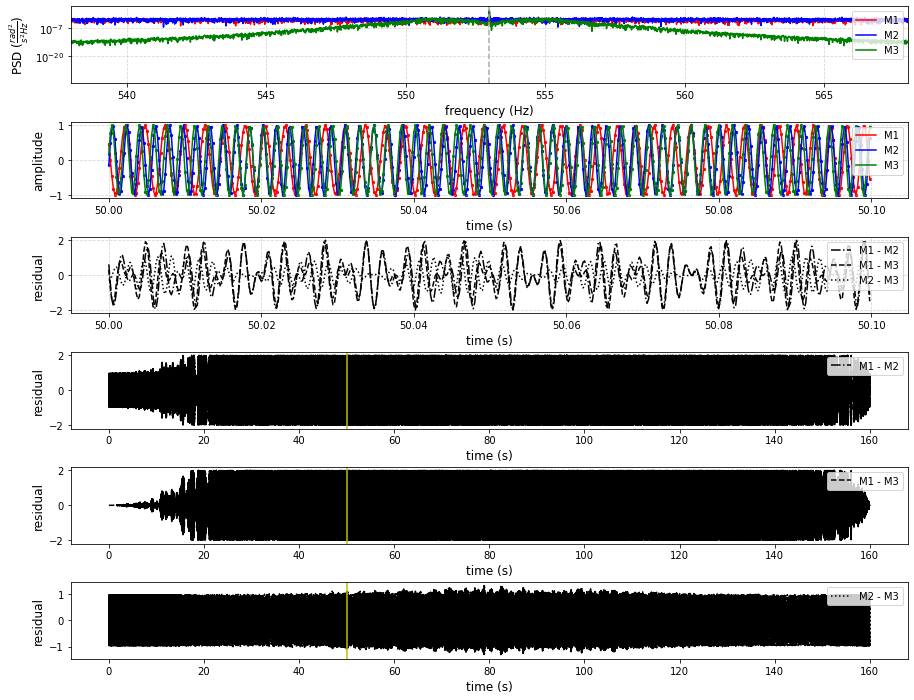

In [13]:
__makeplot_compare_modulation2(syn_signal_1, syn_signal_2, syn_signal_3, timeline_1, sgnc, 50, 500);

### Reverse Oversampling

In [ ]:
modeltrace = modeltrace[::oversampling]
time_modeltrace = time_modeltrace[::oversampling]

syn_signal_1 = syn_signal_1[::oversampling]
timeline_1 = timeline_1[::oversampling]

syn_signal_2 = syn_signal_2[::oversampling]
timeline_2 = timeline_2[::oversampling]

syn_signal_3 = syn_signal_3[::oversampling]
timeline_3 = timeline_3[::oversampling]

sps = 1/(timeline_1[1]-timeline_1[0])

In [ ]:
fig1 = __makeplot_trace_and_spectrum(modeltrace, time_modeltrace, fmax=2*f_upper);

fig2 = __makeplot_compare_modulation2(syn_signal_1, syn_signal_2, syn_signal_3, timeline_1, sgnc, 59, 200);

In [ ]:
oname=f"plots/mod_schemes_{syn_signal}_T{int(T)}_fs{int(sps)}_f{f_lower}-{f_upper}_S{int(sgnc)}_Mind{round(modulation_index,1)}_IN.pdf"
fig1.savefig(oname, dpi=300, format='pdf')

oname=f"plots/mod_schemes_{syn_signal}_T{int(T)}_fs{int(sps)}_f{f_lower}-{f_upper}_S{int(sgnc)}_Mind{round(modulation_index,1)}.pdf"
fig2.savefig(oname, dpi=300, format='pdf')


In [ ]:

# __makeplot_trace_and_spectrum(modeltrace, time_modeltrace, fmax=2*f_upper);


# __makeplot_compare_schemes(syn_signal_1,
#                            time_axis_1,
#                            syn_signal_2,
#                            time_axis_2,
#                            number_of_samples=1200,
#                            shift_of_window=3000,
#                           );
